<a href="https://colab.research.google.com/github/Mmbsaksd/Predicting-Future-Stock-Market-Trends-with-Python-Machine-Learning/blob/main/Predicting_Future_Stock_Market_Trends_with_Python_%26_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing thr required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#importing the required model to train
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neighbors import KNeighborsClassifier

#Importing  the finance and date
import datetime
!pip install finta
from finta import TA
!pip install yfinance
import yfinance as yf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Definig constant for Data Mining
NUM_DAYS = 1000
INTERVAL = '1d'
symbol = 'SPY'

#Creating the list of symbol for technical indicators
INDICATOR = ['RSI','MACD','STOCH','ADL','ATR','MOM','MFI']

In [ ]:
#Pulling the historic data from yfinance
start = (datetime.date.today()- datetime.timedelta(NUM_DAYS))
end = datetime.datetime.today()

data = yf.download(symbol, start = start, end = end, interval = INTERVAL)
data.rename(columns={'Close':'close','High':'high','Low':'low','Volume':'volume','Open':'open','Adj Close':'adj_close'},inplace=True)
data.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,adj_close,volume
Date,,,,,,
2020-01-17 00:00:00-05:00,331.700012,332.179993,330.850006,331.950012,317.897339,95846000
2020-01-21 00:00:00-05:00,330.899994,332.179993,330.820007,331.299988,317.274841,77742400
2020-01-22 00:00:00-05:00,332.239990,332.950012,331.170013,331.339996,317.313110,48914900
2020-01-23 00:00:00-05:00,330.630005,332.170013,329.410004,331.720001,317.677063,51963000
2020-01-24 00:00:00-05:00,332.440002,332.529999,327.359985,328.769989,314.851929,87578400


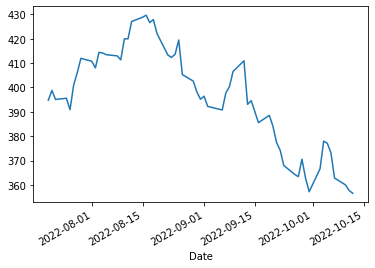

In [ ]:
#Ploting temp data
tmp = data.iloc[-60:]
tmp['close'].plot()

In [ ]:
#Feature engineering for technical indicator implimenting
